# Divvy Bike Share Project Remake
This is my Divvy Bike Project Remake. I completed this project a year ago using R for my Google Data Analytics Certificate. I've learned a lot since then and wanted to see if I could improve upon my prior work as well as demonstrate my ability to analyze data and build visualizations. I'll be using Python for this project because I love pandas 🐼

Here is a link to my original project using R: [https://rpubs.com/Peachtaco/bike_share_analysis](https://rpubs.com/Peachtaco/bike_share_analysis)

## Background
Before diving into the project, I wanted to provide some background on the Divvy Bike Share program. Divvy is a bike sharing program in Chicago that allows users to rent bikes from stations around the city. The program is owned by Lyft and has been around since 2013. The program has over 600 stations and 6,000 bikes with the option to choose an electric bike or classic bike. They offer a variety of passes including single ride, day pass, and annual membership. Customers who purchase a single ride or day pass are considered casual and customers who purchase an annual membership are considered members. My task will be to analyze the data and provide insight on how casual riders and members use the program differently. 

##

## Prepare Data
Divvy trip data is public and available on their [website](https://divvy-tripdata.s3.amazonaws.com/index.html). I downloaded 12 datasets, one for each month from May 2022 to April 2023. I read each CSV file into a dataframe, then concatenated each one into a single dataframe. 
The resulting dataframe contained:

**5,859,061** rows and **13** columns. 

Review of each column showed `ride_id`, is a unique identifier for each ride. `rideable_type` is the type of bike used for the ride. There are 2 columns with datetime data showing the start and end time of each ride. There are 8 columns with location data which include start/end station name/id with corresponding start/end latitude/longtidude. `member_casual` indicates whether the rider is casual or a member. 

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob as glob

In [2]:
# Read and concatenate data
df = pd.concat(map(pd.read_csv, glob.glob("data/*.csv")))
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5859061 entries, 0 to 426589
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             5859061 non-null  object 
 1   rideable_type       5859061 non-null  object 
 2   started_at          5859061 non-null  object 
 3   ended_at            5859061 non-null  object 
 4   start_station_name  5027052 non-null  object 
 5   start_station_id    5026920 non-null  object 
 6   end_station_name    4969400 non-null  object 
 7   end_station_id      4969259 non-null  object 
 8   start_lat           5859061 non-null  float64
 9   start_lng           5859061 non-null  float64
 10  end_lat             5853088 non-null  float64
 11  end_lng             5853088 non-null  float64
 12  member_casual       5859061 non-null  object 
dtypes: float64(4), object(9)
memory usage: 625.8+ MB


### Data Type Check
Review of column data types showed latitude and longitude columns as float type while the remaining columns were object types. 
- `started_at` and `ended_at` columns were converted to datetime type
- A new column `duration` was created by subtracting `started_at` from `ended_at`, then converted to minutes
- `rideable_type` and `member_casual` were converted to category type. 

In [3]:
# Change start and end time column to datetime type
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Create new column for duration of ride in minutes
df['duration'] = df['ended_at'] - df['started_at']
df['duration'] = df['duration'].dt.total_seconds() / 60
df['duration'] = df['duration'].round(2)

# Change rideable_type and member_casual to category type
df['rideable_type'] = df['rideable_type'].astype('category')
df['member_casual'] = df['member_casual'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5859061 entries, 0 to 426589
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  duration            float64       
dtypes: category(2), datetime64[ns](2), float64(5), object(5)
memory usage: 592.3+ MB


### Duplicate Data Check
No duplicate rows were found.

In [5]:
# Check for duplicates
df.duplicated().sum()

0

### Missing Data Check
There was missing data in the `start_station_name`, `start_station_id`, `end_station_name`, and `end_station_id` columns. I considered 2 options for handling the missing data; fill in the missing values or drop the rows with missing values. 

I thought about using the latitude and longitude columns to find the missing station names/ids but the coordinates 

In [6]:
# Check for missing values
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    832009
start_station_id      832141
end_station_name      889661
end_station_id        889802
start_lat                  0
start_lng                  0
end_lat                 5973
end_lng                 5973
member_casual              0
duration                   0
dtype: int64

In [38]:
df = df[df['duration'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4533671 entries, 0 to 426589
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
dtypes: datetime64[ns](2), float64(5), object(7)
memory usage: 518.8+ MB


In [37]:
df.duration.describe()

count    4.533671e+06
mean     1.656188e+01
std      3.622389e+01
min      2.000000e-02
25%      5.870000e+00
50%      1.030000e+01
75%      1.848000e+01
max      3.203545e+04
Name: duration, dtype: float64

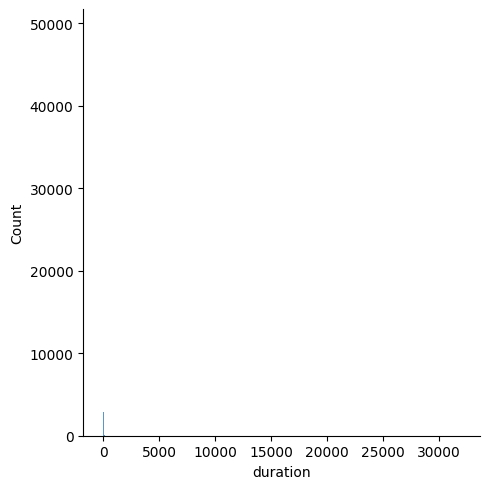

In [29]:
sns.displot(df, x='duration')
plt.show()

In [3]:
# Show missing values in each column
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    832009
start_station_id      832141
end_station_name      889661
end_station_id        889802
start_lat                  0
start_lng                  0
end_lat                 5973
end_lng                 5973
member_casual              0
dtype: int64

In [7]:
df.start_station_id.isnull().sum() - df.start_station_name.isnull().sum()

132

There is a significant amount of missing values in start/end station name/id. I want to review the start stations and end stations separately. 



In [10]:
# Missing start stations
ss = df[(df['start_station_name'].isnull()) | (df['start_station_id'].isnull())]
ss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 832141 entries, 1023 to 424355
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             832141 non-null  object        
 1   rideable_type       832141 non-null  category      
 2   started_at          832141 non-null  datetime64[ns]
 3   ended_at            832141 non-null  datetime64[ns]
 4   start_station_name  132 non-null     object        
 5   start_station_id    0 non-null       object        
 6   end_station_name    435275 non-null  object        
 7   end_station_id      435260 non-null  object        
 8   start_lat           832141 non-null  float64       
 9   start_lng           832141 non-null  float64       
 10  end_lat             832141 non-null  float64       
 11  end_lng             832141 non-null  float64       
 12  member_casual       832141 non-null  category      
 13  duration            832141 non-

In [8]:
ss.head(20)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
1023,440A9ECC93FE147A,electric_bike,2022-05-28 22:13:53,2022-05-28 22:35:40,NaN,NaN,Canal St & Jackson Blvd,13138,41.87,-87.61,41.877245,-87.639366,casual,21.78
1024,54FCB271F53ADA06,electric_bike,2022-05-14 17:34:14,2022-05-14 17:40:28,NaN,NaN,Albany Ave & Bloomingdale Ave,15655,41.91,-87.70,41.914027,-87.705126,member,6.23
2764,194FADFCF10660DF,electric_bike,2022-05-02 15:34:17,2022-05-02 15:44:16,NaN,NaN,Racine Ave & Fullerton Ave,TA1306000026,41.92,-87.64,41.925563,-87.658404,member,9.98
2765,5E4BB191C0881D3E,electric_bike,2022-05-23 15:15:43,2022-05-23 15:26:36,NaN,NaN,Artesian Ave & Hubbard St,15664,41.87,-87.68,41.889492,-87.688219,member,10.88
2766,56C4E69F4F7BF6B7,electric_bike,2022-05-14 20:19:25,2022-05-14 20:26:11,NaN,NaN,Milwaukee Ave & Grand Ave,13033,41.90,-87.65,41.891578,-87.648384,member,6.77
2767,6A8B0AB6265360D5,electric_bike,2022-05-20 20:15:29,2022-05-20 20:28:04,NaN,NaN,Woodlawn Ave & 55th St,TA1307000164,41.79,-87.60,41.795264,-87.596471,member,12.58
2768,3D29A4F674E2530E,electric_bike,2022-05-01 19:09:27,2022-05-01 19:14:15,NaN,NaN,Woodlawn Ave & 55th St,TA1307000164,41.79,-87.59,41.795264,-87.596471,member,4.80
2769,1C3BFC9618B20154,electric_bike,2022-05-27 03:36:09,2022-05-27 03:42:10,NaN,NaN,Milwaukee Ave & Grand Ave,13033,41.89,-87.63,41.891578,-87.648384,member,6.02
2770,7F931168BDE35938,electric_bike,2022-05-19 20:47:53,2022-05-19 21:16:13,NaN,NaN,Michigan Ave & 8th St,623,41.91,-87.63,41.872773,-87.623981,member,28.33
2771,FE7132235311BA24,electric_bike,2022-05-14 21:50:28,2022-05-14 22:49:51,NaN,NaN,Woodlawn Ave & 55th St,TA1307000164,41.71,-87.58,41.795264,-87.596471,casual,59.38


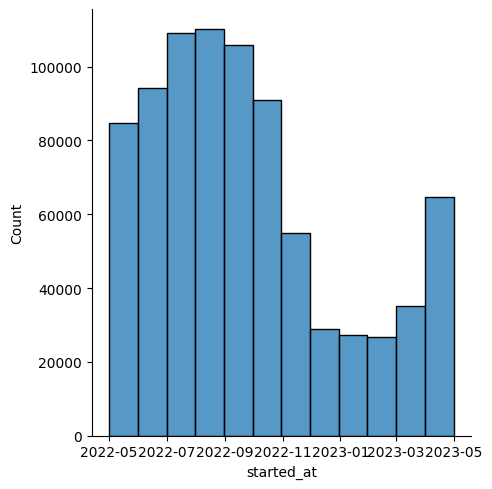

In [11]:
sns.displot(ss, x='started_at', bins=12)
plt.show()

In [13]:
# Missing end stations
es = df[(df['end_station_name'].isnull()) | (df['end_station_id'].isnull())]
es.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889802 entries, 97 to 217254
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             889802 non-null  object        
 1   rideable_type       889802 non-null  object        
 2   started_at          889802 non-null  datetime64[ns]
 3   ended_at            889802 non-null  datetime64[ns]
 4   start_station_name  492937 non-null  object        
 5   start_station_id    492921 non-null  object        
 6   end_station_name    141 non-null     object        
 7   end_station_id      0 non-null       object        
 8   start_lat           889802 non-null  float64       
 9   start_lng           889802 non-null  float64       
 10  end_lat             883829 non-null  float64       
 11  end_lng             883829 non-null  float64       
 12  member_casual       889802 non-null  object        
dtypes: datetime64[ns](2), float64(4),

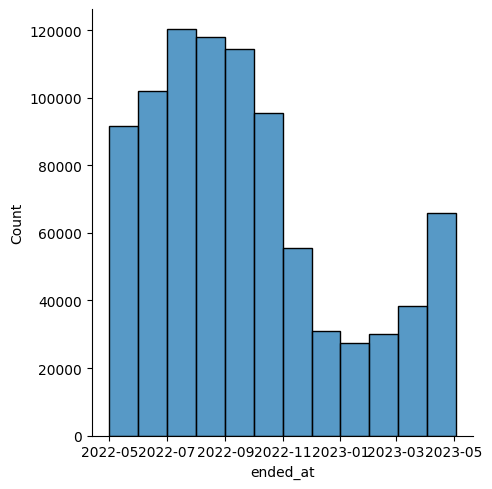

In [14]:
sns.displot(es, x='ended_at', bins=12)
plt.show()

In [17]:
df.dropna(subset=['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], inplace=True)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4533999 entries, 0 to 426589
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             4533999 non-null  object        
 1   rideable_type       4533999 non-null  object        
 2   started_at          4533999 non-null  datetime64[ns]
 3   ended_at            4533999 non-null  datetime64[ns]
 4   start_station_name  4533999 non-null  object        
 5   start_station_id    4533999 non-null  object        
 6   end_station_name    4533999 non-null  object        
 7   end_station_id      4533999 non-null  object        
 8   start_lat           4533999 non-null  float64       
 9   start_lng           4533999 non-null  float64       
 10  end_lat             4533999 non-null  float64       
 11  end_lng             4533999 non-null  float64       
 12  member_casual       4533999 non-null  object        
dtypes: datetime64[ns](

In [16]:
df.isnull().sum()

ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id      120
end_station_name        0
end_station_id        130
start_lat               0
start_lng               0
end_lat                 0
end_lng                 0
member_casual           0
dtype: int64

In [7]:
#Combine latitude and longitude into new column
df['start_coord'] = df['start_lat'].astype(str) + ', ' + df['start_lng'].astype(str)
df['end_coord'] = df['end_lat'].astype(str) + ', ' + df['end_lng'].astype(str)

#Drop old latitude and longitude columns
columnstodrop = ['start_lat', 'start_lng', 'end_lat', 'end_lng']
df.drop(columnstodrop, axis=1, inplace=True)
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,start_coord,end_coord,duration
0,C809ED75D6160B2A,electric_bike,2021-05-30 11:58:15,2021-05-30 12:10:39,NaN,NaN,NaN,NaN,casual,"41.9, -87.63","41.89, -87.61",0 days 00:12:24
1,DD59FDCE0ACACAF3,electric_bike,2021-05-30 11:29:14,2021-05-30 12:14:09,NaN,NaN,NaN,NaN,casual,"41.88, -87.62","41.79, -87.58",0 days 00:44:55
2,0AB83CB88C43EFC2,electric_bike,2021-05-30 14:24:01,2021-05-30 14:25:13,NaN,NaN,NaN,NaN,casual,"41.92, -87.7","41.92, -87.7",0 days 00:01:12
3,7881AC6D39110C60,electric_bike,2021-05-30 14:25:51,2021-05-30 14:41:04,NaN,NaN,NaN,NaN,casual,"41.92, -87.7","41.94, -87.69",0 days 00:15:13
4,853FA701B4582BAF,electric_bike,2021-05-30 18:15:39,2021-05-30 18:22:32,NaN,NaN,NaN,NaN,casual,"41.94, -87.69","41.94, -87.7",0 days 00:06:53


In [8]:
#Change start and end time to datetime data type and create new column with duration. 
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['duration'] = df['ended_at'] - df['started_at']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531633 entries, 0 to 531632
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   ride_id             531633 non-null  object         
 1   rideable_type       531633 non-null  object         
 2   started_at          531633 non-null  datetime64[ns] 
 3   ended_at            531633 non-null  datetime64[ns] 
 4   start_station_name  477889 non-null  object         
 5   start_station_id    477889 non-null  object         
 6   end_station_name    473439 non-null  object         
 7   end_station_id      473439 non-null  object         
 8   member_casual       531633 non-null  object         
 9   start_coord         531633 non-null  object         
 10  end_coord           531633 non-null  object         
 11  duration            531633 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), object(9), timedelta64[ns](1)
memory usage: 48.7+ 

In [23]:
df[(df['end_coord'].str.len() < 14) & (~df['end_station_id'].isnull())].head(20)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,start_coord,end_coord,duration
16513,5A4B53EBD5675F01,electric_bike,2021-05-26 19:03:29,2021-05-26 19:58:27,Wells St & Elm St,KA1504000135,N Carpenter St & W Lake St,20251.0,member,"41.90319483333333, -87.63481","41.89, -87.65",0 days 00:54:58
18196,DB06CF7E538F3119,electric_bike,2021-05-18 16:52:43,2021-05-18 17:00:29,Loomis St & Lexington St,13332,W Washington Blvd & N Peoria St,20247.0,casual,"41.87214183333333, -87.66140816666666","41.88, -87.65",0 days 00:07:46
18412,9E0B43DB0DFBFCAB,electric_bike,2021-05-27 18:30:33,2021-05-27 18:47:14,Michigan Ave & 18th St,13150,W Washington Blvd & N Peoria St,20247.0,member,"41.857817, -87.6244815","41.88, -87.65",0 days 00:16:41
21929,8712C2D30A998293,electric_bike,2021-05-14 18:33:27,2021-05-14 18:46:48,Larrabee St & Webster Ave,13193,N Sheffield Ave & W Wellington Ave,20256.0,casual,"41.9218425, -87.64400083333334","41.94, -87.65",0 days 00:13:21
21939,01F90B8C45155F37,electric_bike,2021-05-15 22:33:58,2021-05-15 22:49:11,Larrabee St & Webster Ave,13193,N Sheffield Ave & W Wellington Ave,20256.0,casual,"41.921817833333336, -87.6440605","41.94, -87.65",0 days 00:15:13
27176,FFF43995A2D44EDE,electric_bike,2021-05-25 13:40:33,2021-05-25 13:44:29,Damen Ave & Cortland St,13133,Damen Ave & Wabansia Ave,20.0,casual,"41.915980833333336, -87.6772375","41.91, -87.68",0 days 00:03:56
27177,22F4E2592D9AD6A2,electric_bike,2021-05-02 13:31:12,2021-05-02 14:14:40,Stockton Dr & Wrightwood Ave,13276,Damen Ave & Wabansia Ave,20.0,casual,"41.931339, -87.63870416666667","41.91, -87.68",0 days 00:43:28
27183,1DAE9B6DA6B5F175,electric_bike,2021-05-08 18:39:32,2021-05-08 18:52:51,Damen Ave & Cortland St,13133,Damen Ave & Wabansia Ave,20.0,member,"41.9159585, -87.67725383333334","41.91, -87.68",0 days 00:13:19
27186,CCFEF8AD7044D79B,electric_bike,2021-05-29 17:04:12,2021-05-29 17:19:50,Clark St & Lincoln Ave,13179,Damen Ave & Wabansia Ave,20.0,casual,"41.91566866666667, -87.63460616666667","41.91, -87.68",0 days 00:15:38
27187,EFE01C725F51BF6D,electric_bike,2021-05-18 21:59:59,2021-05-18 22:09:55,Dayton St & North Ave,13058,Damen Ave & Wabansia Ave,20.0,casual,"41.91059916666666, -87.64939466666667","41.91, -87.68",0 days 00:09:56


In [16]:
df.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    53744
start_station_id      53744
end_station_name      58194
end_station_id        58194
member_casual             0
start_coord               0
end_coord                 0
duration                  0
dtype: int64

In [10]:
df2 = df[df['start_coord'] == df['end_coord']]
df2['start_coord'].value_counts()

start_coord
41.892278, -87.612043                     1560
41.880958, -87.616743                     1114
41.8810317, -87.62408432                   522
41.963982, -87.638181                      521
41.926277, -87.630834                      490
                                          ... 
41.84198816666667, -87.61695566666667        1
41.786691, -87.655859                        1
41.924078, -87.635939                        1
41.831098833333336, -87.62695233333334       1
42.01, -87.72                                1
Name: count, Length: 1261, dtype: int64

In [15]:
df3 = df2[df2['end_station_name'].isnull()]
df3[~df3['start_station_name'].isnull()]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,start_coord,end_coord,duration
240537,056DF0F760882A83,electric_bike,2021-05-08 13:01:27,2021-05-08 13:08:22,W Oakdale Ave & N Broadway,20252.0,NaN,NaN,casual,"41.94, -87.64","41.94, -87.64",0 days 00:06:55
240750,6EBE7F1CA2B51F69,electric_bike,2021-05-24 18:59:03,2021-05-24 19:01:36,W Oakdale Ave & N Broadway,20252.0,NaN,NaN,casual,"41.94, -87.64","41.94, -87.64",0 days 00:02:33
241280,EF88F8BCD87FB162,electric_bike,2021-05-29 01:24:56,2021-05-29 01:30:18,W Oakdale Ave & N Broadway,20252.0,NaN,NaN,casual,"41.94, -87.64","41.94, -87.64",0 days 00:05:22
241663,3591254CC4DF11DA,electric_bike,2021-05-15 16:21:04,2021-05-15 16:24:58,S Wentworth Ave & W 111th St,20128,NaN,NaN,casual,"41.69, -87.63","41.69, -87.63",0 days 00:03:54
242911,B5177182781F6515,electric_bike,2021-05-09 16:31:44,2021-05-09 16:50:49,W Washington Blvd & N Peoria St,20247.0,NaN,NaN,casual,"41.88, -87.65","41.88, -87.65",0 days 00:19:05
242914,022853DB0F6F71CE,electric_bike,2021-05-20 20:36:07,2021-05-20 20:39:27,W Washington Blvd & N Peoria St,20247.0,NaN,NaN,casual,"41.88, -87.65","41.88, -87.65",0 days 00:03:20
247858,A9FFFC2FE362E35D,electric_bike,2021-05-21 19:03:00,2021-05-21 19:11:48,N Green St & W Lake St,20246.0,NaN,NaN,casual,"41.89, -87.65","41.89, -87.65",0 days 00:08:48
248498,6BF4A9DADE5DA0C6,electric_bike,2021-05-22 08:53:40,2021-05-22 08:53:54,N Green St & W Lake St,20246.0,NaN,NaN,member,"41.89, -87.65","41.89, -87.65",0 days 00:00:14
249939,BAB1913A74A2217B,electric_bike,2021-05-14 17:34:22,2021-05-14 17:34:35,N Green St & W Lake St,20246.0,NaN,NaN,casual,"41.89, -87.65","41.89, -87.65",0 days 00:00:13
251323,20E76D5484CBC920,electric_bike,2021-05-01 11:46:02,2021-05-01 11:46:26,Damen Ave & Wabansia Ave,20.0,NaN,NaN,casual,"41.91, -87.68","41.91, -87.68",0 days 00:00:24
